# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import warnings

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
# sort dfdata based on longitude
dfdata = dfdata.sort_values("longitude")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
5962,-180,38,4,-5425.0,NaN,5.702333,NaN,427.678925,34.342628,NaN,15.691460
5757,-180,39,4,-5335.0,NaN,5.829761,NaN,497.673096,34.254448,NaN,14.695810
32077,-180,-55,4,-5287.0,NaN,6.456027,NaN,335.052032,34.125984,NaN,6.751073
5562,-180,40,4,-5241.0,NaN,5.968406,NaN,584.339844,34.158997,NaN,13.663589


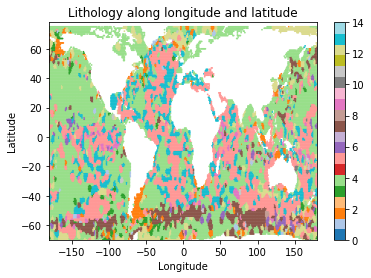

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = pl.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

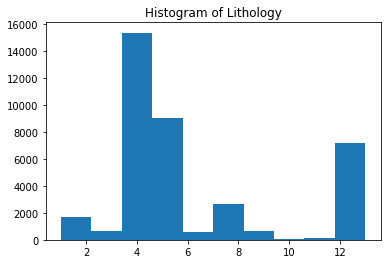

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    pl.hist(y)
    pl.title(title)
    pl.show()

draw_hist(y, "Histogram of Lithology")

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.

In [4]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
warnings.simplefilter("ignore")

Using TensorFlow backend.


### Data preprocessing
* Normalize features X
* Onehot multiclass target Y

In [5]:
# obtain list of feature names
training_data = dfdata.copy()
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# extract X and Y
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

### Construct neural network
The neural network has the following structure:
- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Output layer

In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# parameters for hidden layers
activation = "relu"
initializer = "random_uniform"
dropout_ratio = 0.1
numclass = dummy_Y.shape[1]
N, d = X.shape

# construct layers
inputs = Input(shape=(d,))
layer = Dense(64, activation=activation, kernel_initializer=initializer)(inputs)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(64, activation=activation, kernel_initializer=initializer)(layer)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(32, activation=activation, kernel_initializer=initializer)(layer)
prediction_layer = Dense(numclass, activation="softmax")(layer)

# create model
model = Model(inputs=inputs, outputs=prediction_layer)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                429       
Total para

In [7]:
# shuffle samples
rnd = np.random.RandomState(seed)
shuffle_index = np.arange(N)
rnd.shuffle(shuffle_index)
X = X[shuffle_index]
Y = Y[shuffle_index]
dummy_Y = dummy_Y[shuffle_index]

Train on 24351 samples, validate on 6088 samples
Epoch 1/100
24351/24351 [==============================] - 6s 240us/step - loss: 1.4708 - acc: 0.4908 - val_loss: 1.3747 - val_acc: 0.5172
Epoch 2/100
24351/24351 [==============================] - 6s 228us/step - loss: 1.3879 - acc: 0.5190 - val_loss: 1.3462 - val_acc: 0.5276
Epoch 3/100
24351/24351 [==============================] - 6s 233us/step - loss: 1.3622 - acc: 0.5312 - val_loss: 1.3294 - val_acc: 0.5391
Epoch 4/100
24351/24351 [==============================] - 5s 222us/step - loss: 1.3514 - acc: 0.5345 - val_loss: 1.3170 - val_acc: 0.5432
Epoch 5/100
24351/24351 [==============================] - 5s 224us/step - loss: 1.3371 - acc: 0.5353 - val_loss: 1.3073 - val_acc: 0.5465
Epoch 6/100
24351/24351 [==============================] - 5s 215us/step - loss: 1.3237 - acc: 0.5430 - val_loss: 1.2933 - val_acc: 0.5488
Epoch 7/100
24351/24351 [==============================] - 5s 221us/step - loss: 1.3133 - acc: 0.5412 - val_loss: 1.2

24351/24351 [==============================] - 5s 219us/step - loss: 1.1435 - acc: 0.5857 - val_loss: 1.1360 - val_acc: 0.5861
Epoch 60/100
24351/24351 [==============================] - 5s 215us/step - loss: 1.1446 - acc: 0.5877 - val_loss: 1.1232 - val_acc: 0.5900
Epoch 61/100
24351/24351 [==============================] - 5s 218us/step - loss: 1.1433 - acc: 0.5872 - val_loss: 1.1153 - val_acc: 0.6023
Epoch 62/100
24351/24351 [==============================] - 5s 220us/step - loss: 1.1398 - acc: 0.5885 - val_loss: 1.1276 - val_acc: 0.5885
Epoch 63/100
24351/24351 [==============================] - 5s 220us/step - loss: 1.1402 - acc: 0.5889 - val_loss: 1.1194 - val_acc: 0.5903
Epoch 64/100
24351/24351 [==============================] - 5s 217us/step - loss: 1.1363 - acc: 0.5894 - val_loss: 1.1136 - val_acc: 0.6036
Epoch 65/100
24351/24351 [==============================] - 5s 225us/step - loss: 1.1380 - acc: 0.5859 - val_loss: 1.1170 - val_acc: 0.5959
Epoch 66/100
24351/24351 [=======

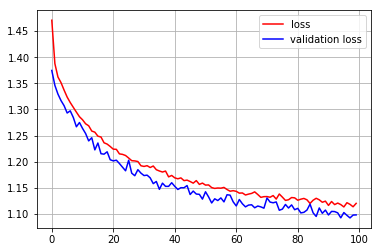

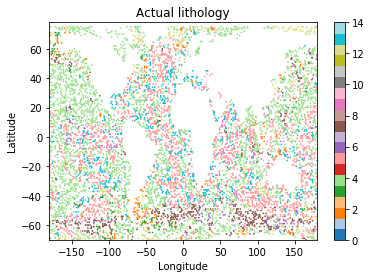

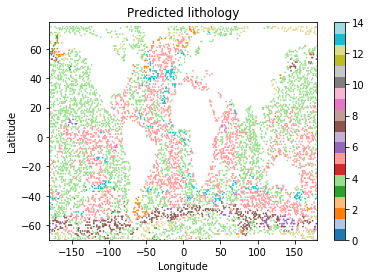

Train on 24351 samples, validate on 6088 samples
Epoch 1/100
24351/24351 [==============================] - 5s 222us/step - loss: 1.1262 - acc: 0.5973 - val_loss: 1.0984 - val_acc: 0.6055
Epoch 2/100
24351/24351 [==============================] - 6s 227us/step - loss: 1.1156 - acc: 0.5962 - val_loss: 1.1025 - val_acc: 0.6051
Epoch 3/100
24351/24351 [==============================] - 5s 225us/step - loss: 1.1236 - acc: 0.5942 - val_loss: 1.1052 - val_acc: 0.6000
Epoch 4/100
24351/24351 [==============================] - 5s 225us/step - loss: 1.1185 - acc: 0.5920 - val_loss: 1.0973 - val_acc: 0.5999
Epoch 5/100
24351/24351 [==============================] - 5s 221us/step - loss: 1.1157 - acc: 0.6002 - val_loss: 1.0909 - val_acc: 0.6046
Epoch 6/100
24351/24351 [==============================] - 5s 225us/step - loss: 1.1179 - acc: 0.5950 - val_loss: 1.0968 - val_acc: 0.6069
Epoch 7/100
24351/24351 [==============================] - 5s 225us/step - loss: 1.1130 - acc: 0.5991 - val_loss: 1.0

24351/24351 [==============================] - 5s 223us/step - loss: 1.0874 - acc: 0.6063 - val_loss: 1.0936 - val_acc: 0.6071
Epoch 60/100
24351/24351 [==============================] - 5s 225us/step - loss: 1.0947 - acc: 0.6044 - val_loss: 1.0780 - val_acc: 0.6040
Epoch 61/100
24351/24351 [==============================] - 5s 223us/step - loss: 1.0883 - acc: 0.6063 - val_loss: 1.0680 - val_acc: 0.6071
Epoch 62/100
24351/24351 [==============================] - 6s 239us/step - loss: 1.0836 - acc: 0.6092 - val_loss: 1.0866 - val_acc: 0.6063
Epoch 63/100
24351/24351 [==============================] - 5s 223us/step - loss: 1.0876 - acc: 0.6055 - val_loss: 1.0707 - val_acc: 0.6112
Epoch 64/100
24351/24351 [==============================] - 6s 231us/step - loss: 1.0882 - acc: 0.6060 - val_loss: 1.0832 - val_acc: 0.6094
Epoch 65/100
24351/24351 [==============================] - 6s 229us/step - loss: 1.0943 - acc: 0.6061 - val_loss: 1.0875 - val_acc: 0.6028
Epoch 66/100
24351/24351 [=======

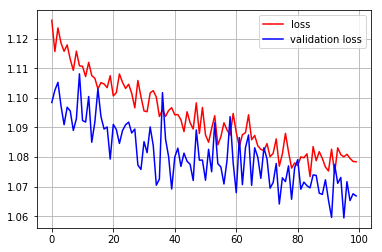

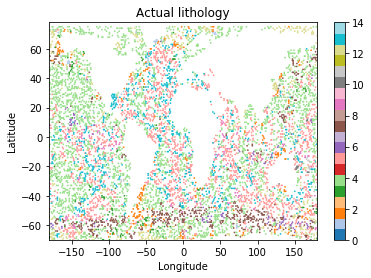

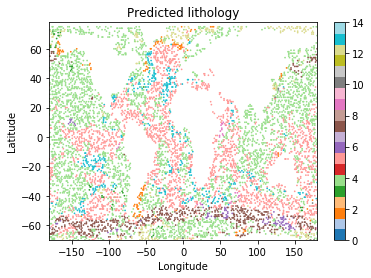

Train on 24351 samples, validate on 6088 samples
Epoch 1/100
24351/24351 [==============================] - 6s 252us/step - loss: 1.1048 - acc: 0.6024 - val_loss: 1.0682 - val_acc: 0.6135
Epoch 2/100
24351/24351 [==============================] - 6s 254us/step - loss: 1.1001 - acc: 0.6032 - val_loss: 1.1006 - val_acc: 0.5953
Epoch 3/100
24351/24351 [==============================] - 6s 252us/step - loss: 1.1012 - acc: 0.6077 - val_loss: 1.0640 - val_acc: 0.6087
Epoch 4/100
24351/24351 [==============================] - 6s 250us/step - loss: 1.0932 - acc: 0.6078 - val_loss: 1.0710 - val_acc: 0.6112
Epoch 5/100
24351/24351 [==============================] - 6s 248us/step - loss: 1.0994 - acc: 0.6022 - val_loss: 1.0786 - val_acc: 0.6076
Epoch 6/100
24351/24351 [==============================] - 6s 246us/step - loss: 1.0979 - acc: 0.6066 - val_loss: 1.0771 - val_acc: 0.6086
Epoch 7/100
24351/24351 [==============================] - 6s 248us/step - loss: 1.0962 - acc: 0.6028 - val_loss: 1.0

24351/24351 [==============================] - 6s 250us/step - loss: 1.0664 - acc: 0.6137 - val_loss: 1.0555 - val_acc: 0.6132
Epoch 60/100
24351/24351 [==============================] - 6s 252us/step - loss: 1.0814 - acc: 0.6068 - val_loss: 1.0641 - val_acc: 0.6059
Epoch 61/100
24351/24351 [==============================] - 6s 250us/step - loss: 1.0732 - acc: 0.6109 - val_loss: 1.0632 - val_acc: 0.6051
Epoch 62/100
24351/24351 [==============================] - 6s 249us/step - loss: 1.0709 - acc: 0.6112 - val_loss: 1.0547 - val_acc: 0.6128
Epoch 63/100
24351/24351 [==============================] - 6s 249us/step - loss: 1.0754 - acc: 0.6114 - val_loss: 1.0566 - val_acc: 0.6105
Epoch 64/100
24351/24351 [==============================] - 6s 249us/step - loss: 1.0687 - acc: 0.6104 - val_loss: 1.0500 - val_acc: 0.6081
Epoch 65/100
24351/24351 [==============================] - 6s 249us/step - loss: 1.0748 - acc: 0.6117 - val_loss: 1.0587 - val_acc: 0.6086
Epoch 66/100
24351/24351 [=======

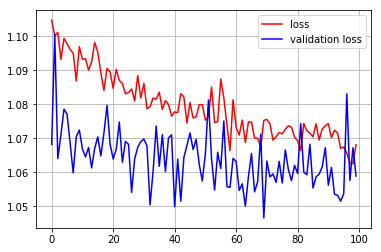

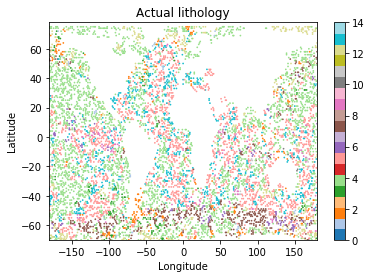

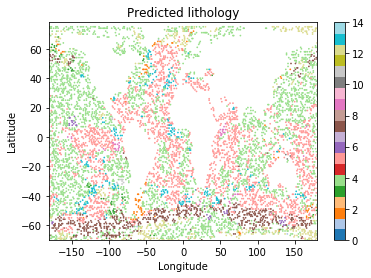

Train on 24351 samples, validate on 6088 samples
Epoch 1/100
24351/24351 [==============================] - 6s 250us/step - loss: 1.0913 - acc: 0.6093 - val_loss: 1.0572 - val_acc: 0.6135
Epoch 2/100
24351/24351 [==============================] - 6s 254us/step - loss: 1.0858 - acc: 0.6109 - val_loss: 1.0503 - val_acc: 0.6166
Epoch 3/100
24351/24351 [==============================] - 6s 251us/step - loss: 1.0854 - acc: 0.6075 - val_loss: 1.0750 - val_acc: 0.6094
Epoch 4/100
24351/24351 [==============================] - 6s 254us/step - loss: 1.0850 - acc: 0.6068 - val_loss: 1.0558 - val_acc: 0.6147
Epoch 5/100
24351/24351 [==============================] - 6s 252us/step - loss: 1.0800 - acc: 0.6059 - val_loss: 1.0532 - val_acc: 0.6128
Epoch 6/100
24351/24351 [==============================] - 6s 251us/step - loss: 1.0832 - acc: 0.6045 - val_loss: 1.0612 - val_acc: 0.6166
Epoch 7/100
24351/24351 [==============================] - 6s 254us/step - loss: 1.0756 - acc: 0.6099 - val_loss: 1.0

24351/24351 [==============================] - 6s 255us/step - loss: 1.0688 - acc: 0.6123 - val_loss: 1.0506 - val_acc: 0.6171
Epoch 60/100
24351/24351 [==============================] - 6s 250us/step - loss: 1.0676 - acc: 0.6150 - val_loss: 1.0540 - val_acc: 0.6150
Epoch 61/100
24351/24351 [==============================] - 6s 253us/step - loss: 1.0699 - acc: 0.6124 - val_loss: 1.0513 - val_acc: 0.6096
Epoch 62/100
24351/24351 [==============================] - 6s 254us/step - loss: 1.0637 - acc: 0.6125 - val_loss: 1.0434 - val_acc: 0.6193
Epoch 63/100
24351/24351 [==============================] - 6s 251us/step - loss: 1.0626 - acc: 0.6155 - val_loss: 1.0570 - val_acc: 0.6081
Epoch 64/100
24351/24351 [==============================] - 6s 248us/step - loss: 1.0678 - acc: 0.6132 - val_loss: 1.0518 - val_acc: 0.6138
Epoch 65/100
24351/24351 [==============================] - 6s 251us/step - loss: 1.0625 - acc: 0.6121 - val_loss: 1.0419 - val_acc: 0.6199
Epoch 66/100
24351/24351 [=======

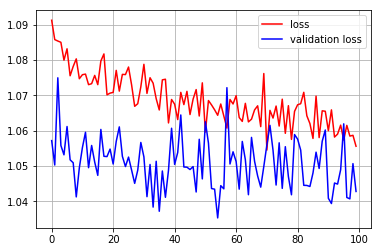

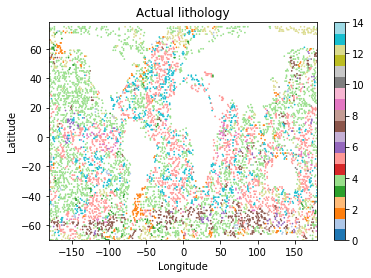

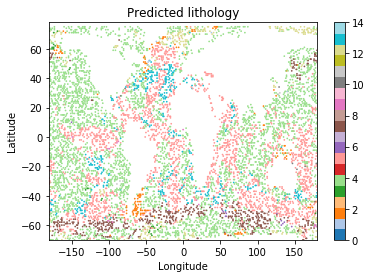

Train on 24352 samples, validate on 6088 samples
Epoch 1/100
24352/24352 [==============================] - 6s 252us/step - loss: 1.0719 - acc: 0.6089 - val_loss: 1.0115 - val_acc: 0.6312
Epoch 2/100
24352/24352 [==============================] - 6s 249us/step - loss: 1.0738 - acc: 0.6140 - val_loss: 1.0156 - val_acc: 0.6307
Epoch 3/100
24352/24352 [==============================] - 6s 253us/step - loss: 1.0683 - acc: 0.6126 - val_loss: 1.0013 - val_acc: 0.6383
Epoch 4/100
24352/24352 [==============================] - 6s 255us/step - loss: 1.0680 - acc: 0.6118 - val_loss: 1.0178 - val_acc: 0.6344
Epoch 5/100
24352/24352 [==============================] - 6s 255us/step - loss: 1.0691 - acc: 0.6155 - val_loss: 1.0099 - val_acc: 0.6358
Epoch 6/100
24352/24352 [==============================] - 6s 249us/step - loss: 1.0664 - acc: 0.6137 - val_loss: 1.0087 - val_acc: 0.6332
Epoch 7/100
24352/24352 [==============================] - 6s 253us/step - loss: 1.0714 - acc: 0.6118 - val_loss: 1.0

24352/24352 [==============================] - 6s 256us/step - loss: 1.0609 - acc: 0.6139 - val_loss: 1.0217 - val_acc: 0.6332
Epoch 60/100
24352/24352 [==============================] - 6s 254us/step - loss: 1.0603 - acc: 0.6126 - val_loss: 1.0276 - val_acc: 0.6316
Epoch 61/100
24352/24352 [==============================] - 6s 252us/step - loss: 1.0611 - acc: 0.6148 - val_loss: 1.0277 - val_acc: 0.6307
Epoch 62/100
24352/24352 [==============================] - 6s 249us/step - loss: 1.0584 - acc: 0.6177 - val_loss: 1.0218 - val_acc: 0.6326
Epoch 63/100
24352/24352 [==============================] - 6s 255us/step - loss: 1.0538 - acc: 0.6151 - val_loss: 1.0110 - val_acc: 0.6355
Epoch 64/100
24352/24352 [==============================] - 6s 258us/step - loss: 1.0589 - acc: 0.6168 - val_loss: 1.0157 - val_acc: 0.6368
Epoch 65/100
24352/24352 [==============================] - 6s 251us/step - loss: 1.0728 - acc: 0.6103 - val_loss: 1.0211 - val_acc: 0.6330
Epoch 66/100
24352/24352 [=======

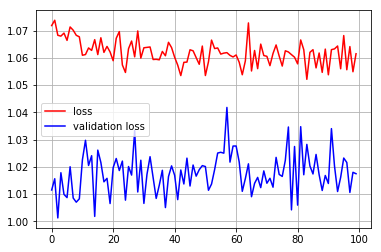

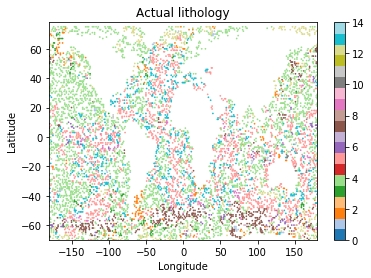

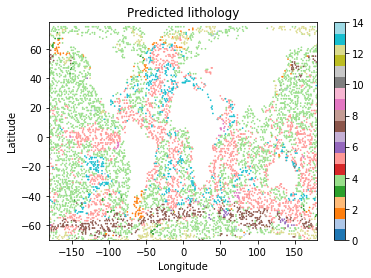

In [8]:
# parameters for training
epochs = 100
batch_size = 5
verbose = True

# use 5 fold cross validation without shuffle
kfold = KFold(n_splits=5, random_state=seed)
lon = dfdata["longitude"].values[shuffle_index]
lat = dfdata["latitude"].values[shuffle_index]

def calculate_entropy(row):
    return -np.sum(row * np.log(row + 1e-10))


# training
prediction = np.zeros((N, numclass))
entropy = np.zeros(N)
for train_ind, test_ind in kfold.split(X):
    train_X, train_Y = X[train_ind], dummy_Y[train_ind]
    # record loss in training and validation
    history = History()
    model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=weight,
              validation_split=0.2, shuffle=True, callbacks=[history])
    # plot loss versus epochs
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    pl.plot(history.epoch, loss, "r-", label="loss")
    pl.plot(history.epoch, val_loss, "b-", label="validation loss")
    pl.grid()
    pl.legend()
    pl.show()
    # predict and draw scatterplot for prediction set
    mu = model.predict(X[test_ind])
    prediction[test_ind, :] = mu
    entropy[test_ind] = np.apply_along_axis(calculate_entropy, 1, mu)
    mean = np.argmax(mu, axis=1)
    draw_global(lon[test_ind], lat[test_ind], Y[test_ind] + 1, "Actual lithology")
    draw_global(lon[test_ind], lat[test_ind], mean + 1, "Predicted lithology")

In [18]:
np.apply_along_axis(calculate_entropy, 1, mu)

array([1.5297935,       nan,       nan, ...,       nan, 1.540843 ,
             nan], dtype=float32)

In [19]:
entropy[np.isnan(entropy)] = 0

### Validate

Accuracy = 0.6237746064285526


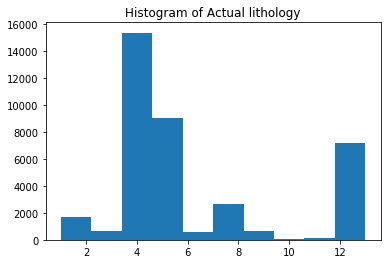

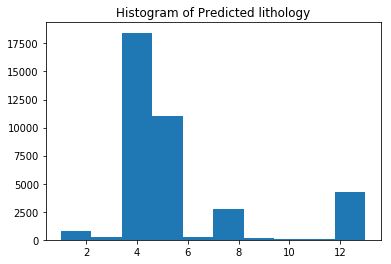

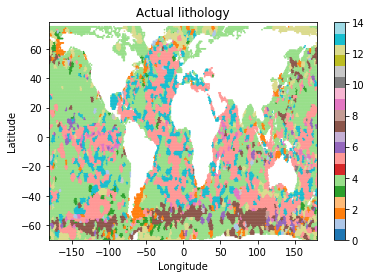

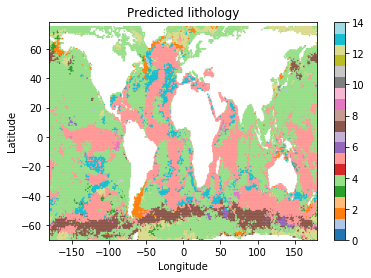

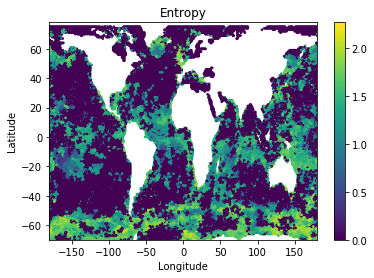

In [20]:
lon = dfdata["longitude"].values[shuffle_index]
lat = dfdata["latitude"].values[shuffle_index]

def draw_prob(lon, lat, p, title, size=3):
    sc = pl.scatter(lon, lat, s=size, c=p)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
    pl.close()
    

mean = np.argmax(prediction, axis=1)
print("Accuracy = {}".format(accuracy_score(Y, mean)))
draw_hist(Y + 1, "Histogram of Actual lithology")
draw_hist(mean + 1, "Histogram of Predicted lithology")
draw_global(lon, lat, Y + 1, "Actual lithology")
draw_global(lon, lat, mean + 1, "Predicted lithology")
draw_prob(lon, lat, entropy, "Entropy")

array([1.38587713, 0.85925376, 1.22418809, ...,        nan, 1.54084301,
              nan])

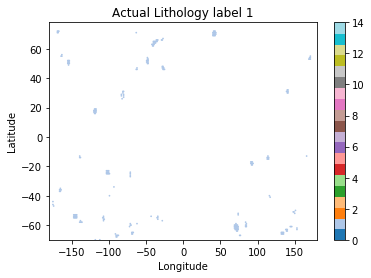

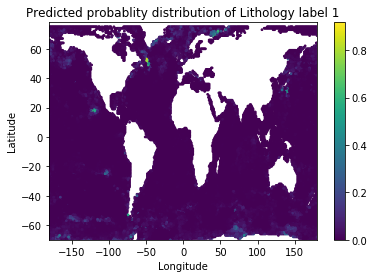

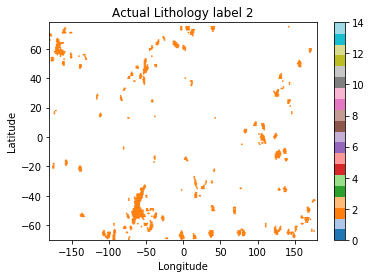

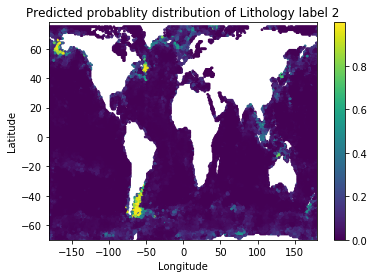

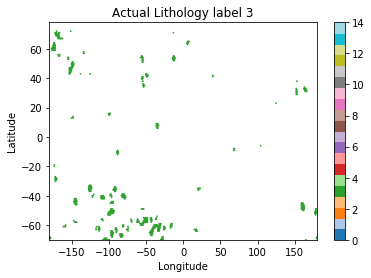

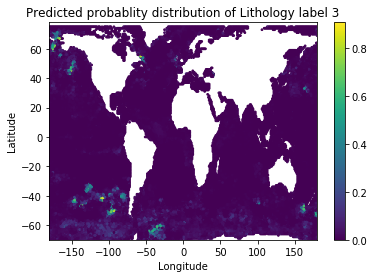

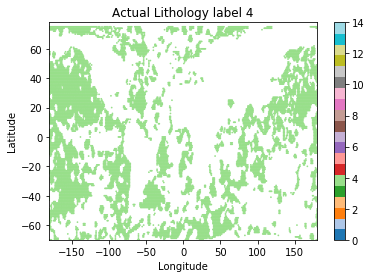

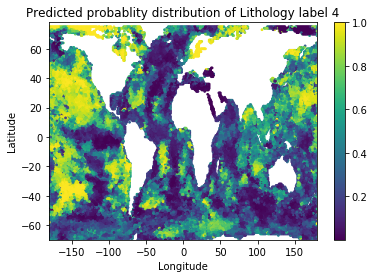

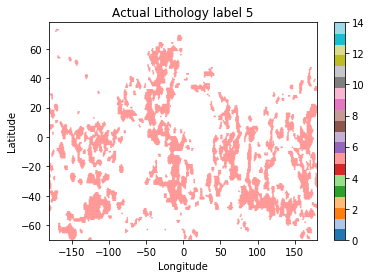

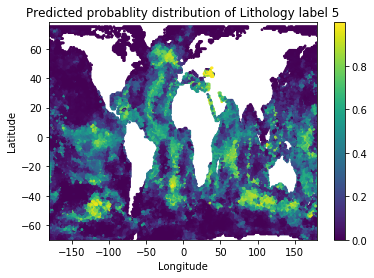

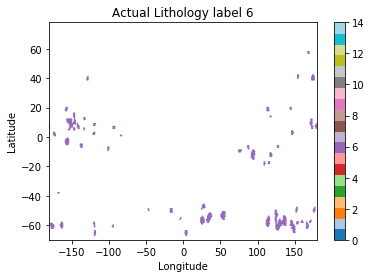

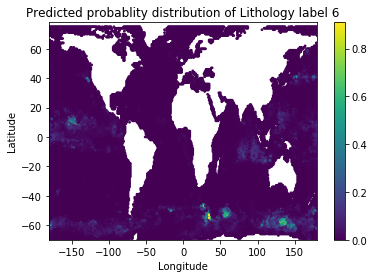

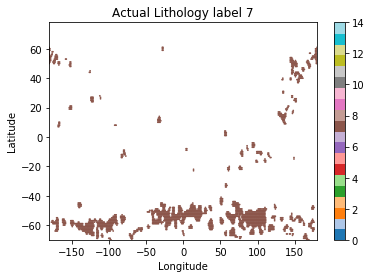

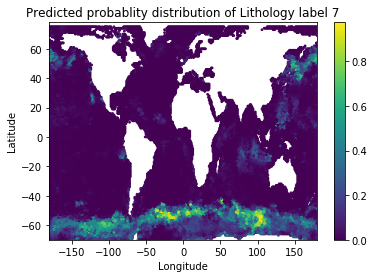

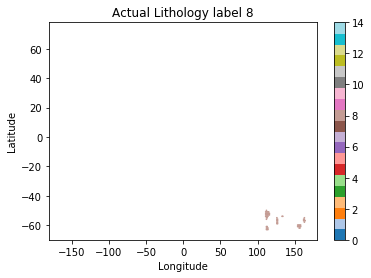

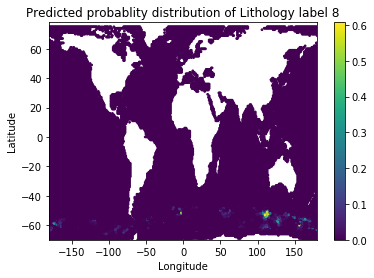

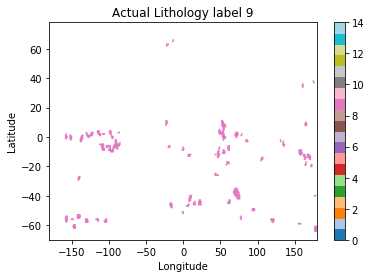

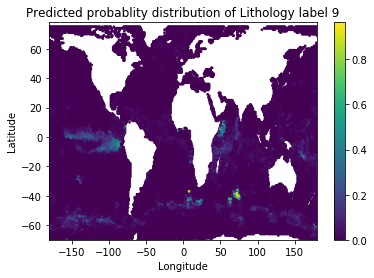

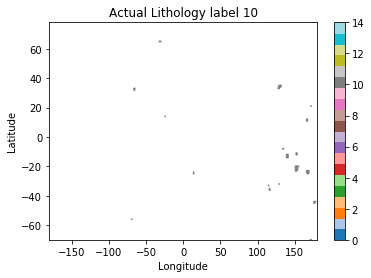

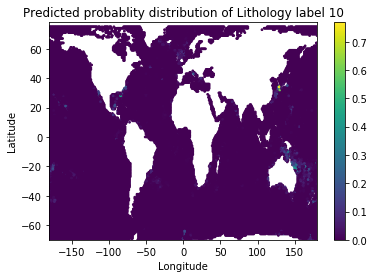

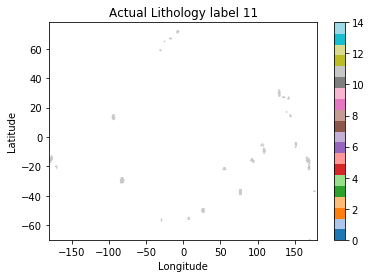

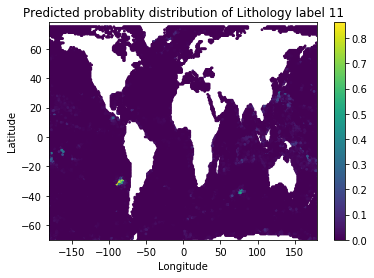

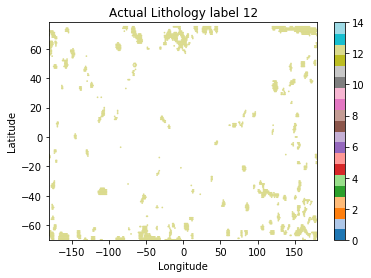

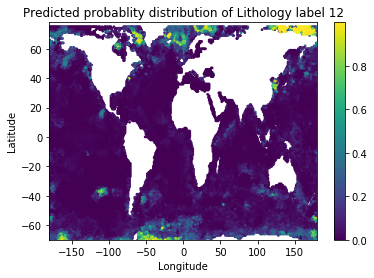

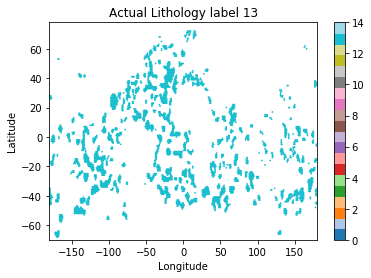

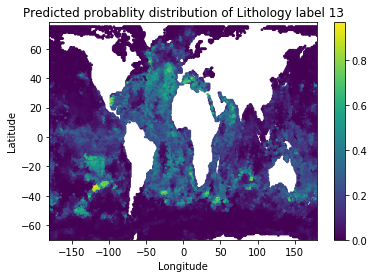

In [10]:
for i in range(13):
    common_part = "Lithology label {}".format(i + 1)
    title_p = "Predicted probablity distribution of {}".format(common_part)
    title_y = "Actual {}".format(common_part)
    # find Y_ts whose label is i + 1 and plot
    index = Y == i
    thisY = Y[Y == i] + 1
    draw_global(lon[index], lat[index], y=thisY, title=title_y)
    # plot prob distribution
    draw_prob(lon, lat, p = prediction[:,i], title=title_p)